In [1]:
# IMPORT
from IPython.display import Image, Math

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from utils import *
import numpy as np
import pandas as pd
import pyAgrum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as pyc
import pyAgrum.causal.notebook as cslnb
from pyAgrum.lib.discretizer import Discretizer
import re
import pickle
from sklearn.cluster import KMeans
from kneed import KneeLocator
from scipy.stats import iqr, gaussian_kde, entropy

In [2]:
def format_evidence_for_latex(evidence):
    formatted_evidence = []
    
    for var in evidence.keys():
        # Replace the part after the underscore with curly braces, if applicable
        var = re.sub(r'_(\w+)', r'_{\1}', var)  # Add {} around the part after the underscore
        
        # Replace '0' with '_{t-1}'
        var = var.replace('t', '_t')
        var = var.replace('0', '_{t-1}')

        # Append formatted variable to the list
        formatted_evidence.append(f"${var}$")  # Adding $ for LaTeX format
        
    return ', '.join(formatted_evidence)

def plot_distributions(var, distributions, var_midpoints, xlabel, ylabel):
    # Number of distributions to plot
    n = len(distributions)
    
    # Create subplots (one for each distribution)
    fig, axes = plt.subplots(1, n, figsize=(12, 4))

    # If there's only one plot, axes is not a list, so we handle it separately
    if n == 1:
        axes = [axes]
    var_midpoints = [round(float(m),2) for m in var_midpoints]
    for i, (data, title) in enumerate(distributions):
        # Plot the distribution in the corresponding subplot
        axes[i].bar(range(len(data)), data)
        axes[i].set_xticks(range(len(data)), var_midpoints)
        var_str = format_evidence_for_latex({var: None})
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()
    
def find_bin(value, edges):
    """
    Given a continuous value and an array of bin edges,
    return the index of the bin that contains the value.
    """
    idx = np.digitize(value, edges, right=False) - 1
    return int(max(0, min(idx, len(edges) - 2)))


def get_info(D, auditDict, var):
    quantiles = np.linspace(0, 100, auditDict[var]['param'] + 1 if 'param' in auditDict[var] else auditDict[var]['nbBins'] + 1)
    edges = np.percentile(D[var].values, quantiles)
    midpoints = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
    return quantiles, edges, midpoints


def optimal_bins_elbow_method(time_series, min_bins=2, max_bins=15, plot=True):
    """
    Determines the optimal number of bins using the elbow method with KMeans clustering.

    Parameters:
    - time_series: numpy array or list of numerical values (1D time series)
    - min_bins: minimum number of bins to consider
    - max_bins: maximum number of bins to consider
    - plot: whether to plot the elbow curve

    Returns:
    - optimal_bins: The optimal number of bins for discretization
    """
    time_series = np.array(time_series).reshape(-1, 1)  # Ensure data is 2D for KMeans

    inertia_values = []
    bin_range = range(min_bins, max_bins + 1)

    for k in bin_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(time_series)
        inertia_values.append(kmeans.inertia_)

    # Use KneeLocator to find the elbow point
    kneedle = KneeLocator(bin_range, inertia_values, curve="convex", direction="decreasing")
    optimal_bins = kneedle.elbow

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(bin_range, inertia_values, marker="o", linestyle="-", label="Inertia")
        plt.axvline(optimal_bins, linestyle="--", color="red", label=f"Optimal Bins: {optimal_bins}")
        plt.xlabel("Number of Bins (Clusters)")
        plt.ylabel("Inertia (WCSS)")
        plt.title("Elbow Method for Optimal Bin Selection")
        plt.legend()
        plt.grid(True)
        plt.show()

    return optimal_bins



def optimal_bins(timeseries):
    """
    Determines the optimal number of bins for a given time series using
    the Freedman-Diaconis rule and KL Divergence comparison with KDE.

    Parameters:
    - timeseries: array-like, the time series data.

    Returns:
    - best_bins: int, the optimal number of bins.
    - best_method: str, the name of the best method.
    - all_bins: dict, dictionary of bins per method.
    """
    
    # Compute data range
    N = len(timeseries)
    range_data = np.max(timeseries) - np.min(timeseries)

    # Different binning rules
    bin_methods = {
        "Sturges": int(np.log2(N) + 1),
        "Rice": int(2 * N**(1/3)),
        "Scott": int(range_data / (3.5 * np.std(timeseries) / N**(1/3))),
        "Freedman-Diaconis": int(range_data / (2 * iqr(timeseries) / N**(1/3)))
    }

    # KDE estimation for ground truth density
    kde = gaussian_kde(timeseries)
    x_vals = np.linspace(np.min(timeseries), np.max(timeseries), 1000)
    kde_vals = kde(x_vals)

    # KL Divergence evaluation
    kl_scores = {}

    for name, bins in bin_methods.items():
        hist, bin_edges = np.histogram(timeseries, bins=bins, density=True)
        
        # Convert histogram to probability density function
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        hist_interp = np.interp(x_vals, bin_centers, hist, left=0, right=0)
        
        # Compute KL Divergence (measuring difference from KDE)
        kl_div = entropy(hist_interp + 1e-8, kde_vals + 1e-8)  # Small value to prevent log(0)
        kl_scores[name] = kl_div

    # Select the best binning method (lowest KL divergence)
    best_method = min(kl_scores, key=kl_scores.get)
    print(f"Best binning method: {best_method}")
    best_bins = bin_methods[best_method]

    return best_bins

In [3]:
# DATA
DAGDIR = '/home/lcastri/git/causalflow/results/BL100_21102024/res.pkl'
INDIR = '/home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/hrisim_postprocess/csv'
BAGNAME= ['test-obs-21022025']

for bagname in BAGNAME:
    for wp in WP:
        dfs = []
        if wp == WP.PARKING or wp == WP.CHARGING_STATION: continue
        for tod in TOD:
            if tod is TOD.OFF: continue
            files = [f for f in os.listdir(os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}"))]
            files_split = [f.split('_') for f in files]
            wp_files = [f for f in files_split if len(f) == 3 and f[2].split('.')[0] == wp.value][0]
            wp_file = '_'.join(wp_files)
            print(f"Loading : {wp_file}")
            filename = os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}", wp_file)

            df = pd.read_csv(filename)
            dfs.append(df)
        concat_df = pd.concat(dfs, ignore_index=True)
        break

    
D = concat_df.drop('pf_elapsed_time', axis=1)
D = D.drop('T', axis=1)
D = D.drop('R_X', axis=1)
D = D.drop('R_Y', axis=1)
D = D.drop('G_X', axis=1)
D = D.drop('G_Y', axis=1)
D = D.drop('NP', axis=1)
D = D.drop('R_B', axis=1)
D = D.drop('C_S', axis=1)
D = D.drop('TOD', axis=1)
D = D.drop('WP', axis=1)
D = D.drop('PD', axis=1)
original_names = list(D.columns)
# D.columns = [f'{v}t' for v in original_names]

# Add lagged variable
# for v in original_names:
#     D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
# D = D.iloc[1:].reset_index(drop=True)  # Remove first row
# D = D.iloc[:-1].reset_index(drop=True)  # Remove last row


Loading : test-obs-21022025_H1_door-entrance.csv
Loading : test-obs-21022025_H2_door-entrance.csv
Loading : test-obs-21022025_H3_door-entrance.csv
Loading : test-obs-21022025_H4_door-entrance.csv
Loading : test-obs-21022025_H5_door-entrance.csv
Loading : test-obs-21022025_H6_door-entrance.csv
Loading : test-obs-21022025_H7_door-entrance.csv
Loading : test-obs-21022025_H8_door-entrance.csv
Loading : test-obs-21022025_H9_door-entrance.csv
Loading : test-obs-21022025_H10_door-entrance.csv


/tmp/ipykernel_1463921/2023867229.py:12: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  template = discretizer.discretizedBN(D)



** audit **
- R_V : 
    + method : quantile
    + param : 4
    + type : Continuous
    + minInData : 1.723819877985644e-05
    + maxInData : 0.5090284679674543
- OBS : 
    + method : NoDiscretization
    + values : [0. 1.]
    + type : Discrete
- EC : 
    + method : quantile
    + param : 3
    + type : Continuous
    + minInData : 0.0276565551757812
    + maxInData : 0.3561096191406392


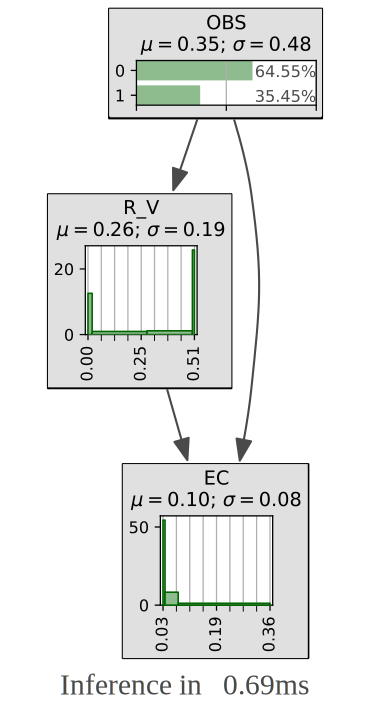

In [4]:
# DISCRETIZATION -- BN CREATION

discretizer=Discretizer(defaultDiscretizationMethod='quantile')
RV_bins = optimal_bins_elbow_method(D['R_V'].values, plot=False)
EC_bins = optimal_bins_elbow_method(D['EC'].values, plot=False)
discretizer.setDiscretizationParameters('R_V','quantile', RV_bins)
discretizer.setDiscretizationParameters('EC','quantile', EC_bins)

template = discretizer.discretizedBN(D)
auditDict=discretizer.audit(D)
print()
print("** audit **")
for var in auditDict:
    print(f"- {var} : ")
    for k,v in auditDict[var].items():
        print(f"    + {k} : {v}")
        
template.addArc("OBS", "EC")
template.addArc("OBS", "R_V")
template.addArc("R_V", "EC")
learner = pyAgrum.BNLearner(D, template)
learner.useSmoothingPrior()
bn = learner.learnParameters(template)

gnb.showInference(bn, size="10!")

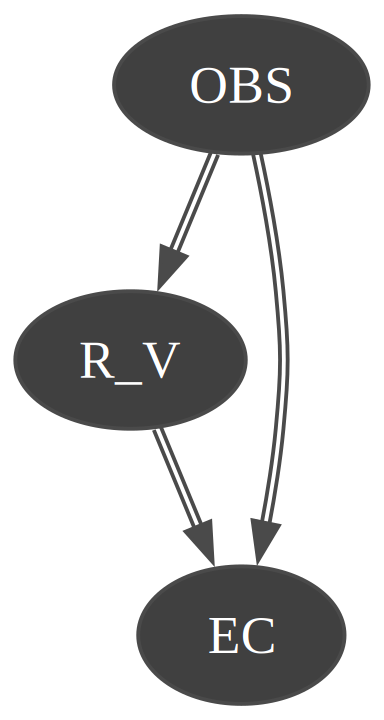

<IPython.core.display.Math object>

In [68]:
cm = pyc.CausalModel(bn)

# ------------------------------
# Evaluate Predictions on a Test Set using BN inference and CausalModel (do-intervention)
# ------------------------------
cslnb.showCausalModel(cm, size="10!")
a = pyc.doCalculusWithObservation(cm,"EC", {"R_V"})
display(Math(a.toLatex()))

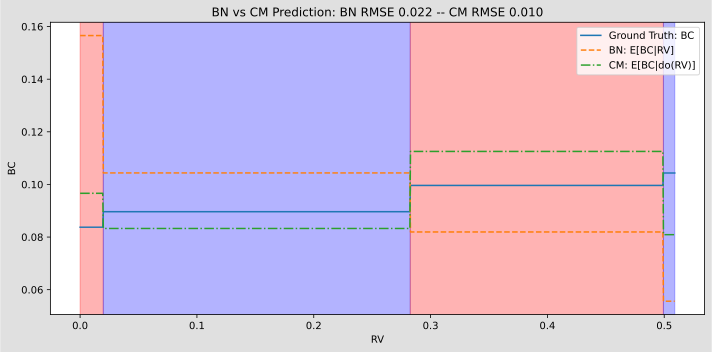

In [69]:
static_duration = 5
dynamic_duration = 4
charging_time = 2
LOAD_FACTOR = 5
ROBOT_MAX_VEL = 0.5
K_nl_s = 100 / (static_duration * 3600)
K_nl_d = (100 / (dynamic_duration * 3600) - K_nl_s)/(ROBOT_MAX_VEL)
K_l_s = K_nl_s * LOAD_FACTOR
K_l_d = K_nl_d * LOAD_FACTOR

quantiles_R_V0, edges_R_V0, midpoints_R_V0 = get_info(D, auditDict, 'R_V')
quantiles_EC0, edges_EC0, midpoints_EC0 = get_info(D, auditDict, 'EC')
STEP = 5
time = 5
gt_noload = []
gt_load = []
gts = []
bayes_preds = []
causal_preds = []

RV_range = np.linspace(min(edges_R_V0), max(edges_R_V0), 1000)
# RV_range = edges_R_V0
for RV_val in RV_range:
    RV_bin_idx = find_bin(RV_val, edges_R_V0)
    RV_val = midpoints_R_V0[RV_bin_idx]
    GTLOAD = time * (K_l_s + K_l_d * RV_val) 
    GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)

    target_var = 'EC'
    target_var_str = format_evidence_for_latex({target_var: None})
        
    # --- BN prediction ---
    ie = pyAgrum.VariableElimination(bn)
    bn_prior = ie.posterior(target_var)
    evidence = {"R_V": RV_bin_idx}
    evidence_str = format_evidence_for_latex(evidence)
    ie.setEvidence(evidence)
    ie.makeInference()
    bn_posterior = ie.posterior(target_var)
    bn_posterior_values = bn_posterior.toarray()
    pred_bn = sum(bn_posterior_values[j] * midpoints_EC0[j] for j in range(len(bn_posterior_values)))
    bayes_pred = (time/STEP)*pred_bn
        
    # --- CausalModel prediction ---
    formula, adj, exp = pyc.causalImpact(cm, on="EC", doing="R_V", values=evidence)
    posterior_causal = adj.toarray()
    pred_causal = sum(posterior_causal[j] * midpoints_EC0[j] for j in range(len(posterior_causal)))
    causal_pred = (time/STEP)*pred_causal
        
    gt_noload.append(GTNOLOAD)
    gt_load.append(GTLOAD)
    gts.append((GTNOLOAD+GTLOAD)/2)
    bayes_preds.append(bayes_pred)
    causal_preds.append(causal_pred)

plt.figure(figsize=(10, 5))
# plt.plot(midpoints_R_V0, gt_noload, label=f'Ground Truth: BC', linestyle='-')
# plt.plot(midpoints_R_V0, gt_load, label=f'Ground Truth: BC', linestyle='-')
plt.plot(RV_range, gts, label=f'Ground Truth: BC', linestyle='-')
plt.plot(RV_range, bayes_preds, label=f'BN: E[BC|RV]', linestyle='--')
plt.plot(RV_range, causal_preds, label=f'CM: E[BC|do(RV)]', linestyle='-.')
# Add vertical bands (shade regions)
plotB = True
for j in range(1, len(edges_R_V0)):
    if plotB:
        plt.axvspan(edges_R_V0[j-1], edges_R_V0[j], color='r', alpha=0.3)  # Adjust alpha for transparency
        plotB = False
    else:
        plt.axvspan(edges_R_V0[j-1], edges_R_V0[j], color='b', alpha=0.3)  # Adjust alpha for transparency
        plotB = True
        
# Add error bars at bin midpoints
bn_RMSE = np.sqrt(np.mean((np.array(bayes_preds) - np.array(gts)) ** 2))
cm_RMSE = np.sqrt(np.mean((np.array(causal_preds) - np.array(gts)) ** 2))
plt.title(f'BN vs CM Prediction: BN RMSE {bn_RMSE:.3f} -- CM RMSE {cm_RMSE:.3f}')
plt.xlabel(r'RV')
plt.ylabel(r'BC')
plt.legend()
plt.tight_layout()
plt.show()



In [5]:
import numpy as np
import matplotlib.pyplot as plt
quantiles_R_V0, edges_R_V0, midpoints_R_V0 = get_info(D, auditDict, 'R_V')
quantiles_EC0, edges_EC0, midpoints_EC0 = get_info(D, auditDict, 'EC')
STEP = 5
time = 5
gt_noload = []
gt_load = []
gts = []
bayes_preds = []
causal_preds = []

RV_range = midpoints_R_V0
for RV_val in RV_range:
    RV_bin_idx = find_bin(RV_val, edges_R_V0)
    RV_val = midpoints_R_V0[RV_bin_idx]
    GTLOAD = time * (K_l_s + K_l_d * RV_val) 
    GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)

    target_var = 'EC'
    target_var_str = format_evidence_for_latex({target_var: None})
        
    # --- BN prediction ---
    ie = pyAgrum.VariableElimination(bn)
    bn_prior = ie.posterior(target_var)
    evidence = {"R_V": RV_bin_idx}
    evidence_str = format_evidence_for_latex(evidence)
    ie.setEvidence(evidence)
    ie.makeInference()
    bn_posterior = ie.posterior(target_var)
    bn_posterior_values = bn_posterior.toarray()
    pred_bn = sum(bn_posterior_values[j] * midpoints_EC0[j] for j in range(len(bn_posterior_values)))
    bayes_pred = (time/STEP)*pred_bn
        
    # --- CausalModel prediction ---
    formula, adj, exp = pyc.causalImpact(cm, on="EC", doing="R_V", values=evidence)
    posterior_causal = adj.toarray()
    pred_causal = sum(posterior_causal[j] * midpoints_EC0[j] for j in range(len(posterior_causal)))
    causal_pred = (time/STEP)*pred_causal
        
    gt_noload.append(GTNOLOAD)
    gt_load.append(GTLOAD)
    gts.append((GTNOLOAD+GTLOAD)/2)
    bayes_preds.append(bayes_pred)
    causal_preds.append(causal_pred)

# Define bar width and offsets
bar_width = 0.25
x_indexes = np.arange(len(RV_range))

# Compute absolute errors
cm_errors = np.abs(np.array(causal_preds) - np.array(gts))
bn_errors = np.abs(np.array(bayes_preds) - np.array(gts))

# Compute Mean Absolute Error (MAE)
cm_MAE = np.mean(cm_errors)
bn_MAE = np.mean(bn_errors)

plt.figure(figsize=(12, 6))

# Plot bars for each category with offset
plt.bar(x_indexes - bar_width, gts, width=bar_width, label="Ground Truth", color='tab:blue', alpha=1)
plt.bar(x_indexes, bayes_preds, width=bar_width, label=r"BN: E[$\Delta R_B$|$R_V$,$C_S$]", color='tab:orange', alpha=1)
plt.bar(x_indexes + bar_width, causal_preds, width=bar_width, label=r"CM: E[$\Delta R_B$|do($R_V$),$C_S$]", color='tab:green', alpha=1)

# Add absolute errors as text at the base of BN and CM bars
for i in range(len(x_indexes)):
    plt.text(x_indexes[i], 0.005, f"AE: {bn_errors[i]:.3f}", ha='center', va='bottom', fontsize=10, color='black', rotation=90)
    plt.text(x_indexes[i] + bar_width, 0.005, f"AE: {cm_errors[i]:.3f}", ha='center', va='bottom', fontsize=10, color='black', rotation=90)
    
# Labeling
plt.xlabel(r"$R_V$ Bins")
plt.ylabel(r"$\Delta R_B$")
plt.xticks(x_indexes, [f"({edges_R_V0[i-1]:.4f}, {edges_R_V0[i]:.4f})" for i in range(1, len(edges_R_V0))])  # Format x-axis labels
plt.title(r"Comparison of $\Delta R_B$ " + f"Estimations per Velocity Band\nBN MAE: {bn_MAE:.3f} -- CM MAE: {cm_MAE:.3f}")
plt.legend()
plt.tight_layout()

plt.show()


NameError: name 'K_l_s' is not defined

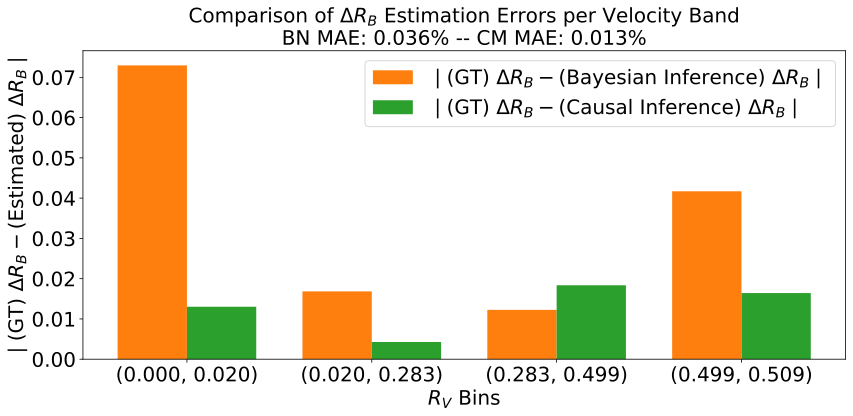

In [78]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')  # Resets to standard Matplotlib styling
quantiles_R_V0, edges_R_V0, midpoints_R_V0 = get_info(D, auditDict, 'R_V')
quantiles_EC0, edges_EC0, midpoints_EC0 = get_info(D, auditDict, 'EC')
STEP = 5
time = 5
gt_noload = []
gt_load = []
gts = []
bayes_preds = []
causal_preds = []

RV_range = midpoints_R_V0
for RV_val in RV_range:
    RV_bin_idx = find_bin(RV_val, edges_R_V0)
    RV_val = midpoints_R_V0[RV_bin_idx]
    GTLOAD = time * (K_l_s + K_l_d * RV_val) 
    GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)

    target_var = 'EC'
    target_var_str = format_evidence_for_latex({target_var: None})
        
    # --- BN prediction ---
    ie = pyAgrum.VariableElimination(bn)
    bn_prior = ie.posterior(target_var)
    evidence = {"R_V": RV_bin_idx}
    evidence_str = format_evidence_for_latex(evidence)
    ie.setEvidence(evidence)
    ie.makeInference()
    bn_posterior = ie.posterior(target_var)
    bn_posterior_values = bn_posterior.toarray()
    pred_bn = sum(bn_posterior_values[j] * midpoints_EC0[j] for j in range(len(bn_posterior_values)))
    bayes_pred = (time/STEP)*pred_bn
        
    # --- CausalModel prediction ---
    formula, adj, exp = pyc.causalImpact(cm, on="EC", doing="R_V", values=evidence)
    posterior_causal = adj.toarray()
    pred_causal = sum(posterior_causal[j] * midpoints_EC0[j] for j in range(len(posterior_causal)))
    causal_pred = (time/STEP)*pred_causal
        
    gt_noload.append(GTNOLOAD)
    gt_load.append(GTLOAD)
    gts.append((GTNOLOAD+GTLOAD)/2)
    bayes_preds.append(bayes_pred)
    causal_preds.append(causal_pred)

# Define bar width and offsets
bar_width = 0.375
x_indexes = np.arange(len(RV_range))

# Compute absolute errors
cm_errors = np.abs(np.array(causal_preds) - np.array(gts))
bn_errors = np.abs(np.array(bayes_preds) - np.array(gts))

# Compute Mean Absolute Error (MAE)
cm_MAE = np.mean(cm_errors)
bn_MAE = np.mean(bn_errors)

plt.figure(figsize=(12, 6))

# Plot bars for each category with offset
plt.bar(x_indexes, bn_errors, width=bar_width, label=r"$\mid (\text{GT})~\Delta R_{B} - (\text{Bayesian Inference})~\Delta R_{B} \mid$", color='tab:orange', alpha=1)
plt.bar(x_indexes + bar_width, cm_errors, width=bar_width, label=r"$\mid (\text{GT})~\Delta R_{B} - (\text{Causal Inference})~\Delta R_{B} \mid$", color='tab:green', alpha=1)

# Labeling
plt.xlabel(r"$R_V$ Bins", fontdict={'fontsize': 20})
plt.ylabel(r"$\mid (\text{GT})~\Delta R_{B} - (\text{Estimated})~\Delta R_{B} \mid$", fontdict={'fontsize': 20})
plt.xticks(x_indexes+bar_width/2, [f"({edges_R_V0[i-1]:.3f}, {edges_R_V0[i]:.3f})" for i in range(1, len(edges_R_V0))], fontdict={'fontsize': 20})  # Format x-axis labels
plt.yticks(fontsize= 20)
plt.title(r"Comparison of $\Delta R_B$ " + f"Estimation Errors per Velocity Band\nBN MAE: {bn_MAE:.3f}% -- CM MAE: {cm_MAE:.3f}%", fontdict={'fontsize': 20})
plt.legend(fontsize=20)
plt.tight_layout()

plt.show()

In [72]:
static_duration = 5
dynamic_duration = 4
charging_time = 2
LOAD_FACTOR = 5
NOLOAD_ROBOT_MAX_VEL = 0.75
LOAD_ROBOT_MAX_VEL = 0.25
K_nl_s = 100 / (static_duration * 3600)
K_nl_d = (100 / (dynamic_duration * 3600) - K_nl_s)/(NOLOAD_ROBOT_MAX_VEL)
K_l_s = K_nl_s * LOAD_FACTOR
K_l_d = K_nl_d * LOAD_FACTOR

quantiles_R_V0, edges_R_V0, midpoints_R_V0 = get_info(D, auditDict, 'R_V')
quantiles_EC0, edges_EC0, midpoints_EC0 = get_info(D, auditDict, 'EC')
STEP = 5
time = 5

RV_val = 0.5
RV_bin_idx = find_bin(RV_val, edges_R_V0)
RV_val = midpoints_R_V0[RV_bin_idx]
GTLOAD = time * (K_l_s + K_l_d * RV_val) 
GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)

target_var = 'EC'
target_var_str = format_evidence_for_latex({target_var: None})

# --- BN prediction ---
ie = pyAgrum.VariableElimination(bn)
bn_prior = ie.posterior(target_var)
evidence = {"R_V": RV_bin_idx}
evidence_str = format_evidence_for_latex(evidence)
ie.setEvidence(evidence)
ie.makeInference()
bn_posterior = ie.posterior(target_var)
bn_posterior_values = bn_posterior.toarray()
pred_bn = sum(bn_posterior_values[j] * midpoints_EC0[j] for j in range(len(bn_posterior_values)))
bayes_pred = (time/STEP)*pred_bn
        
# --- CausalModel prediction ---
formula, adj, exp = pyc.causalImpact(cm, on="EC", doing="R_V", values=evidence)
posterior_causal = adj.toarray()
pred_causal = sum(posterior_causal[j] * midpoints_EC0[j] for j in range(len(posterior_causal)))
causal_pred = (time/STEP)*pred_causal
        
print(f"GT {(GTNOLOAD+GTLOAD)/2:.3f}")
print(f"BN {bayes_pred:.3f} -- AE {np.abs(bayes_pred - (GTNOLOAD+GTLOAD)/2):.3f}")
print(f"CM {causal_pred:.3f} -- AE {np.abs(causal_pred - (GTNOLOAD+GTLOAD)/2):.3f}")

GT 0.097
BN 0.056 -- AE 0.042
CM 0.081 -- AE 0.016


In [73]:
quantiles_R_V0, edges_R_V0, midpoints_R_V0 = get_info(D, auditDict, 'R_V0')
quantiles_EC0, edges_EC0, midpoints_EC0 = get_info(D, auditDict, 'EC0')

# OBS PRIOR DISTRIBUTION
R_V_selection = D
counts, bins = np.histogram(R_V_selection['OBS0'].values, bins=2)
plt.hist([0, 1], bins, weights=counts/sum(counts), width=0.4, alpha=1, label='OBS')
plt.xticks([0.2, 0.7], ['0', '1'])
plt.xlim([-0.1, 1])
plt.xlabel('OBS')
plt.ylabel(f'p(OBS)')
plt.title(f"Prior Distribution of OBS")
plt.show()

# RV 
RV_val = 0.49
RV_bin_idx = find_bin(RV_val, edges_R_V0)

## OBS GIVEN RV
R_V_selection = D[abs(D['R_V0'] - RV_val) < 0.05]
counts, bins = np.histogram(R_V_selection['OBS0'].values, bins=2)
plt.hist([0, 1], bins, weights=counts/sum(counts), width=0.4, alpha=1, label='OBS')
plt.xticks([0.2, 0.7], ['0', '1'])
plt.xlim([-0.1, 1])
plt.xlabel('OBS')
plt.ylabel(f'p(OBS|RV = {RV_val})')
plt.title(f"Distribution of OBS given RV")
plt.show()

## BC GIVEN RV OBS = 0
OBS_val = 0
ie = pyAgrum.VariableElimination(bn)
bn_prior = ie.posterior(target_var)
evidence = {"R_V0": RV_bin_idx, "OBS0": OBS_val}
evidence_str = format_evidence_for_latex(evidence)
ie.setEvidence(evidence)
ie.makeInference()
bn_posterior = ie.posterior(target_var)
bn_posterior_values = bn_posterior.toarray()
plot_distributions("EC0", [(bn_posterior_values, "")], midpoints_EC0, xlabel="BC", ylabel=f"p(BC|OBS = {OBS_val}, RV = {RV_val})")

## BC GIVEN RV OBS = 1
OBS_val = 1
ie = pyAgrum.VariableElimination(bn)
bn_prior = ie.posterior(target_var)
evidence = {"R_V0": RV_bin_idx, "OBS0": OBS_val}
evidence_str = format_evidence_for_latex(evidence)
ie.setEvidence(evidence)
ie.makeInference()
bn_posterior = ie.posterior(target_var)
bn_posterior_values = bn_posterior.toarray()
plot_distributions("EC0", [(bn_posterior_values, "")], midpoints_EC0, xlabel="BC", ylabel=f"p(BC|OBS = {OBS_val}, RV = {RV_val})")

KeyError: 'R_V0'